Let's first initialize the matrices and some variables

In [1]:
from generate_sparse_matrix import generate_sparse_matrix
from accesses_calculation import input_accesses_calculation
from accesses_calculation import output_accesses_calculation
from bandwidth_calculation import input_bandwidth_calculation
from bandwidth_calculation import output_bandwidth_calculation
from MAC_units_usage import MAC_units_usage_gust
from bitmap_encode import bitmap_encode_row_major
from avg_reuse_distance import avg_reuse_distance
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

# Matrix generation
In_data_size = 8  # has to be a multiple of 8 such that the memory locations are not segmented
Out_data_size = 24  # has to be a multiple of 8 such that the memory locations are not segmented

# In gustavson they are row major for X (multiple of 8)
meta_chunk_size = 32

X_rows, X_columns, X_sparsity = 4, 4, 0.5  # X_columns = Y_rows
Y_rows, Y_columns, Y_sparsity = 4, 4, 0.9

X_elem_size, Y_elem_size = 2, 2

X = generate_sparse_matrix(X_rows, X_columns, X_sparsity, In_data_size)
Y = generate_sparse_matrix(Y_rows, Y_columns, Y_sparsity, In_data_size)
Z = [['0' * Out_data_size for _ in range(Y_columns)] for _ in range(X_rows)]

# Conversion of X matrix into Bitmap representation
X_nonzero_values, X_mask = bitmap_encode_row_major(X)

# Initialization of vectors of data usage
X_offset_addr = []
Y_offset_addr = []
Z_offset_addr = []

# build a vector as long as the mask where each nonzero element has been substituted by its position in the dense vector
X_value_indices = []
val_idx = 0
for bit in X_mask:
    if bit == 1:
        X_value_indices.append(val_idx)
        val_idx += 1
    else:
        X_value_indices.append(None)

# Latency initialization
latency = 0

# Number of tiles for X and Y
Y_column_blocks = math.ceil(Y_columns / Y_elem_size)

Now we simulate the calculation using this 3 nested loops; one along the rows of X, one along che column blocks of Y and one along both the column blocks of X and row blocks of Y; inside this three nested loops we have two other nested loops that just compute the result; once this has been done, the list of access patterns is updated

In [2]:
meta_iters = math.ceil(X_columns * X_rows / meta_chunk_size)
# This cycle loads the metadata chunks
for meta_chunk in range(meta_iters):

    # Load the metadata of a row of X and compute global k indices where X_mask[k] == 1 inside this row of X
    start_meta = meta_chunk * meta_chunk_size
    end_meta = min(start_meta + meta_chunk_size, X_columns * X_rows)
    X_meta_positions = [k for k in range(start_meta, end_meta) if
                        X_mask[
                            k] == 1]  # Keeps the row major indices of the nonzero X elements of X in the metadata block

    # I lose a cycle to load the metadata chunk
    X_offset_addr.append([math.ceil(start_meta / 8)])
    Y_offset_addr.append([])
    Z_offset_addr.append([])
    latency += 1

    if len(X_meta_positions) != 0:
        # Compute the number of iterations along the vertical dimension
        starting_row = min(X_meta_positions) // X_columns
        ending_row = max(X_meta_positions) // X_columns
        X_row_iters = ending_row - starting_row + 1
    else:
        starting_row = 0
        X_row_iters = 0

    for X_row in range(X_row_iters):

        # Indices of data belonging to the same row
        X_row_positions = [x for x in X_meta_positions if
                           (starting_row + X_row) * X_columns <= x < (starting_row + X_row + 1) * X_columns]

        # Compute the number of iterations along the k dimension
        k_iters = math.ceil(len(X_row_positions) / X_elem_size)

        for Y_column_block in range(Y_column_blocks):

            start_Y = Y_column_block * Y_elem_size
            end_Y = min(start_Y + Y_elem_size, Y_columns)

            # Output buffer initialization
            out_buffer = ['0' * Out_data_size] * (end_Y - start_Y)

            for tile in range(k_iters):

                start_X = tile * X_elem_size
                end_X = min(start_X + X_elem_size, len(X_row_positions))

                # Take a slice of the meta positions
                X_row_positions_tile = X_row_positions[
                                       start_X:end_X]  # Keeps the indices of the nonzero elements of the row tile of X
                # Pad globals so we always have X_elem_size entries even in the last iteration
                pad_len = X_elem_size - len(X_row_positions_tile)
                X_row_positions_tile += [None] * pad_len

                # Load X tile by taking all the values in X_value_indices whose id is in the current tile ids list
                X_tile = [
                    X_nonzero_values[X_value_indices[k]] if k is not None else '0' * In_data_size
                    for k in X_row_positions_tile
                ]

                empty_row = ['0' * In_data_size] * (end_Y - start_Y)

                # Load Y tile
                Y_tile = [
                    (Y[k - (starting_row + X_row) * X_columns][start_Y:end_Y] if k is not None else empty_row)
                    for k in X_row_positions_tile
                ]

                # Multiply-accumulate
                for x_idx, x_bin in enumerate(X_tile):
                    x_val = int(x_bin, 2)
                    for y_idx in range(end_Y - start_Y):
                        y_val = int(Y_tile[x_idx][y_idx], 2)
                        acc = int(out_buffer[y_idx], 2)
                        acc += x_val * y_val
                        acc &= (1 << Out_data_size) - 1
                        out_buffer[y_idx] = format(acc, f'0{Out_data_size}b')

                # Store back
                Z[starting_row + X_row][start_Y:end_Y] = out_buffer

                # region APPENDING DATA ITEMS INFORMATION

                # Offset addresses for the current cycle
                Y_start_addr = Y_column_block * Y_elem_size * Y_rows
                Z_start_addr = ((starting_row + X_row) * Y_columns + Y_column_block * Y_elem_size) * (
                            Out_data_size / 8)

                # Load the addresses of the accessed elements of each matrix for this cycle
                cycle_X = [
                    math.ceil(X_columns * X_rows / 8) + X_value_indices[k] * (In_data_size / 8)
                    for k in X_row_positions_tile if k is not None
                ]

                cycle_Y = []
                for step in range(end_Y - start_Y):
                    base_offset = step * (Y_rows * (In_data_size / 8))
                    for k in range(end_X - start_X):
                        if X_row_positions_tile[k] is not None:
                            addr = (Y_start_addr + base_offset + (
                                        X_row_positions_tile[k] - (starting_row + X_row) * X_columns))
                            cycle_Y.append(addr * (In_data_size / 8))
                cycle_Z = [Z_start_addr + i * (Out_data_size / 8) for i in range(end_Y - start_Y)]

                # Add the cycle address information to the list
                X_offset_addr.append(cycle_X)
                Y_offset_addr.append(cycle_Y)
                Z_offset_addr.append(cycle_Z)

                # endregion

                latency += 1

# At the end as final step I add a stall for the first load cycle and the last store cycle where no computation is done

X_offset_addr = X_offset_addr + [[]] + [[]]
Y_offset_addr = Y_offset_addr + [[]] + [[]]
Z_offset_addr_fetch = [[] for _ in range(len(X_offset_addr))]
Z_offset_addr_store = [[]] + [[]] + Z_offset_addr

# I calculate the average utilization of the

Avg_accelerator_utilization = MAC_units_usage_gust(Y_offset_addr, X_elem_size * Y_elem_size)

# Now I turn the list into the actual accesses to memory using a function

X_offset_addr = input_accesses_calculation(X_offset_addr)
Y_offset_addr = input_accesses_calculation(Y_offset_addr)
Z_offset_addr_fetch = input_accesses_calculation(Z_offset_addr_fetch)
Z_offset_addr_store = output_accesses_calculation(Z_offset_addr_store)

Now that the calculation is complete and we've gathered enough data we put everything together by calculating some figures of merit

In [3]:
# FINAL LATENCY CALCULATION

latency = latency + 2

# BANDWIDTH CALCULATION

Input_avg_bandwidth, Input_peak_bandwidth = input_bandwidth_calculation(X_offset_addr,
                                                                        Y_offset_addr,
                                                                        Z_offset_addr_fetch,
                                                                        In_data_size, Out_data_size,
                                                                        math.ceil(meta_chunk_size / 8),
                                                                        math.ceil(X_columns * X_rows / 8))
Output_avg_bandwidth, Output_peak_bandwidth = output_bandwidth_calculation(Z_offset_addr_store,
                                                                           Out_data_size)

Combined_avg_bandwidth = Input_avg_bandwidth + Output_avg_bandwidth
Combined_peak_bandwidth = Input_peak_bandwidth + Output_peak_bandwidth

# REUSE DISTANCE CALCULATION

X_reuse_distance = avg_reuse_distance(X_offset_addr)
Y_reuse_distance = avg_reuse_distance(Y_offset_addr)
Z_reuse_distance = 0

Now we print these figure of merit and plot the results

Reuse policy: Z

Latency: 13.0 cycles
Average Input bandwidth: 4.5 Bytes/ cycle
Peak Input bandwidth: 6.0 Bytes/ cycle
Average Output bandwidth: 3.3 Bytes/ cycle
Peak Output bandwidth: 6.0 Bytes/ cycle
Average Combined bandwidth: 7.7 Bytes/ cycle
Peak Combined bandwidth: 12.0 Bytes/ cycle
Average MACs utilisation: 72.7 %
X Reuse Distance (cycles): 1.0
Y Reuse Distance (cycles): 3.0
Z Reuse Distance (cycles): 0.0



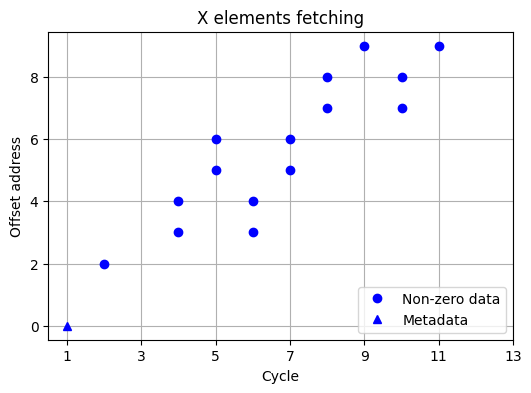

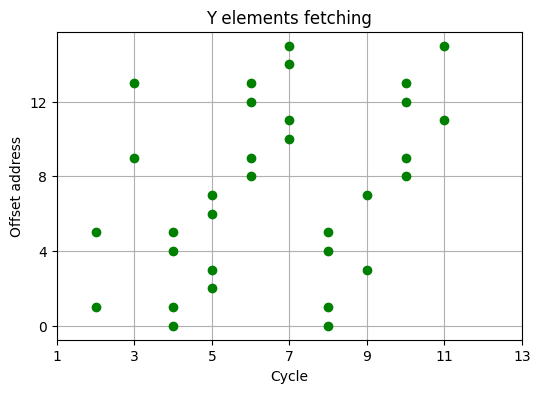

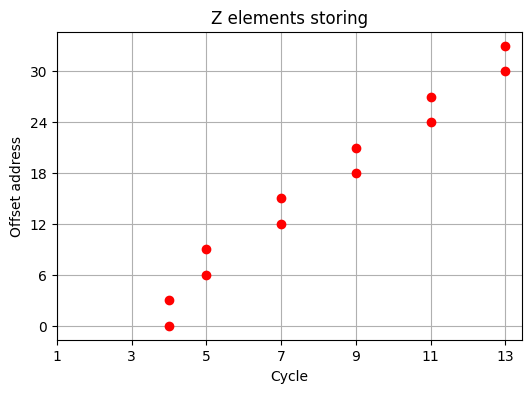

In [4]:
# region PRINTING AND DATA ITEMS PLOT

print("Reuse policy: Z\n")
print(f"Latency: {latency:.1f} cycles")
print(f"Average Input bandwidth: {Input_avg_bandwidth:.1f} Bytes/ cycle")
print(f"Peak Input bandwidth: {Input_peak_bandwidth:.1f} Bytes/ cycle")
print(f"Average Output bandwidth: {Output_avg_bandwidth:.1f} Bytes/ cycle")
print(f"Peak Output bandwidth: {Output_peak_bandwidth:.1f} Bytes/ cycle")
print(f"Average Combined bandwidth: {Combined_avg_bandwidth:.1f} Bytes/ cycle")
print(f"Peak Combined bandwidth: {Combined_peak_bandwidth:.1f} Bytes/ cycle")
print(f"Average MACs utilisation: {Avg_accelerator_utilization:.1f} %")
print(f"X Reuse Distance (cycles): {X_reuse_distance:.1f}")
print(f"Y Reuse Distance (cycles): {Y_reuse_distance:.1f}")
print(f"Z Reuse Distance (cycles): {Z_reuse_distance:.1f}\n")

indices = [(X_offset_addr, 'Offset address', 'X elements fetching', 'blue', 'o', Y_column_blocks,
            X_elem_size * (In_data_size / 8)),
           (Y_offset_addr, 'Offset address', 'Y elements fetching', 'green', 'o', Y_column_blocks,
            (Y_rows * (In_data_size / 8))),
           (Z_offset_addr_store, 'Offset address', 'Z elements storing', 'red', 'o', Y_column_blocks,
            X_elem_size * (Out_data_size / 8))]

for vals, y_label, label, color, marker, x_spacing, y_spacing in indices:
    plt.figure(figsize=(6, 4))

    threshold = math.ceil(X_columns * X_rows / 8)
    x = np.arange(1, len(vals) + 2)

    for i, cycle in enumerate(vals):
        this_marker = marker

        if label == 'X elements fetching' and cycle:
            # Convert to numeric if needed
            numeric_vals = [
                int(item, 2) if isinstance(item, str) else item
                for item in cycle
            ]
            max_val = max(numeric_vals)
            if max_val < threshold:
                this_marker = '^'  # Metadata marker

        plt.plot(
            [i + 1] * len(cycle),
            cycle,
            color=color,
            marker=this_marker,
            linestyle='None'
        )

    # Add legend only for the X-fetch plot
    if label == 'X elements fetching':
        legend_handles = [
            Line2D([0], [0], marker='o', color=color, linestyle='None',
                   label='Non-zero data'),
            Line2D([0], [0], marker='^', color=color, linestyle='None',
                   label='Metadata'),
        ]
        plt.legend(handles=legend_handles, loc='lower right')

    plt.xlabel('Cycle')
    plt.ylabel(y_label)
    plt.title(f'{label}')

    plt.xticks(np.arange(min(x), max(x) + 1, x_spacing))

    all_nums = [
        int(item, 2) if isinstance(item, str) else item
        for sub in vals for item in sub
    ]
    plt.yticks(np.arange(0, max(all_nums) + 1, y_spacing))

    plt.grid(True)
    plt.show()

# endregion

Finally we print the actual results of the computation

In [5]:
print("Matrix X:")
for row in X:
    print(row)

print("\nMatrix Y:")
for row in Y:
    print(row)

print("\nResult Z:")
for row in Z:
    print(row)

Matrix X:
['00000000', '11011110', '00000000', '00000000']
['01111000', '10011101', '00100001', '01110111']
['00111011', '01000010', '00000000', '11011000']
['00000000', '00000000', '00000000', '00000000']

Matrix Y:
['00000000', '00000101', '00000000', '00000000']
['00000000', '00000000', '00000000', '11000101']
['00000000', '00000000', '00000000', '00000000']
['00000000', '00000000', '00000000', '00000000']

Result Z:
['000000000000000000000000', '000000000000000000000000', '000000000000000000000000', '000000001010101011010110']
['000000000000000000000000', '000000000000001001011000', '000000000000000000000000', '000000000111100011010001']
['000000000000000000000000', '000000000000000100100111', '000000000000000000000000', '000000000011001011001010']
['000000000000000000000000', '000000000000000000000000', '000000000000000000000000', '000000000000000000000000']
